動画から生データの出力
30fps、640×360に対応

In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import os

In [2]:
#フォルダ名
movie = "puyopuyo_saikyo_league/movie/ぷよぷよ最強マッキーmomoken"
folder = "puyopuyo_saikyo_league/stats/s1_day8_maki_momoken_2"
#試合開始時間
Initial = (0*60+3)*30
#最後のスコアが表示されている時間
Time = (55*60+32)*30
#総試合数
games = 53

In [6]:
os.makedirs(folder)

In [10]:
#ツモ数出力・画面のずれ検出に使用するための元画像tumo.jpgを出力
#試合開始から15秒について画像を出力し、ネクストぷよが動いていない状態の画像をtumo.jpgとして使用(手動で名前変更)

#動画情報取得#
cap = cv2.VideoCapture(movie+".mp4")

num = 0
N = Initial + 450

while(num<N):
    ret, frame = cap.read()
    
    if ret:
        if num > Initial:
            #画像出力
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            filepath = folder+"/tumo_"+str(num)+".jpg"
            cv2.imwrite(filepath, frame)
            
    num += 1

In [3]:
#開始1分についてbatu_1p.jpg, batu_2p.jpgを取得する
#試合開始から1分(60秒=1800FRAME)についてbatu.jpgに最も近い画像を1p,2pともに出力

#動画情報取得#
cap = cv2.VideoCapture(movie+".mp4")

#初期化
num = 0
N = Initial + 1800
rensa_list_1p = []
rensa_list_2p = []
#比較用の「×」(得点計算の×、1連鎖毎に表示される)画像読み込み
batu = cv2.imread("puyosnap_num/batu.jpg")
batu_GRAY = cv2.cvtColor(batu, cv2.COLOR_BGR2GRAY)

while(num<N):
    ret, frame = cap.read()
    if num>Initial:
        if ret:
            #1p, 2pそれぞれについて「×」の領域をフレームごとに比較し、差分の2乗の総和をrensa_list_1p. rensa_list_2pに格納
            rensa_temp_1p = cv2.cvtColor(frame[298:310, 172:183], cv2.COLOR_BGR2GRAY)
            sub = (rensa_temp_1p.astype(int) - batu_GRAY.astype(int)) ** 2
            rensa_list_1p.append(np.sum(sub))
        
            rensa_temp_2p = cv2.cvtColor(frame[298:310, 472:483], cv2.COLOR_BGR2GRAY)
            sub = (rensa_temp_2p.astype(int) - batu_GRAY.astype(int)) ** 2
            rensa_list_2p.append(np.sum(sub))
            
    #試合開始前は1000000を格納(最小値を取るので邪魔しないように大きな値)
    else:
        rensa_list_1p.append(1000000)
        rensa_list_2p.append(1000000)
    num += 1

#差分が最も小さい(=「×」が表示されている)フレームを取得
min_1p = rensa_list_1p.index(min(rensa_list_1p))
min_2p = rensa_list_2p.index(min(rensa_list_2p))

#動画情報取得#
cap = cv2.VideoCapture(movie+".mp4")

num = 0
while(num<N):
    ret, frame = cap.read()
    if ret:
        #「×」が表示されているフレームで「×」の画像(batu_1p, batu_2p)を取得
        if (num==min_1p):
            img_1p_batu = frame[298:310, 172:183]
            filepath = folder+"/batu_1p.jpg"
            cv2.imwrite(filepath, img_1p_batu)

        if (num==min_2p):
            img_2p_batu = frame[298:310, 472:483]
            filepath = folder+"/batu_2p.jpg"
            cv2.imwrite(filepath, img_2p_batu)

    num += 1

In [4]:
#変数imgに対してスコアの数字(1p-1の位、10の位 & 2p-1の位、10の位)を求める
#(★注意★)精度が安定しない場合、後で手動でエラーを起こしている値を修正する必要あり
def obtain_score(img):
    #1p1の位、2p1の位、1p10の位、2p10の位の画像を取得
    img_1p_1 = img[324:335, 280:287]
    img_2p_1 = img[324:335, 362:369]
    img_1p_10 = img[324:335, 271:278]
    img_2p_10 = img[324:335, 353:360]

    #数字画像を比較し差分の二乗の総和をsub_listに格納、最小値のindexを取得して1p1の位を取得
    sub_list = []    
    for i in range(10):
        img_num = cv2.imread("puyosnap_num/"+str(i)+".jpg")
        sub = (img_num.astype(int) - img_1p_1.astype(int)) ** 2
        sub_list.append(np.sum(sub))
    score_1p_1 = sub_list.index(min(sub_list))

    #数字画像を比較し差分の二乗の総和をsub_listに格納、最小値のindexを取得して1p10の位を取得
    sub_list = []
    for i in range(10):
        img_num = cv2.imread("puyosnap_num/"+str(i)+".jpg")
        sub = (img_num.astype(int) - img_1p_10.astype(int)) ** 2
        sub_list.append(np.sum(sub))
    #最小値が1500000以上の場合(1桁)、10を格納
    if min(sub_list) < 1500000:
        score_1p_10 = sub_list.index(min(sub_list))
    else:
        score_1p_10 = 10
    
    #数字画像を比較し差分の二乗の総和をsub_listに格納、最小値のindexを取得して2p1の位を取得
    sub_list = []
    for i in range(10):
        img_num = cv2.imread("puyosnap_num/"+str(i)+".jpg")
        sub = (img_num.astype(int) - img_2p_1.astype(int)) ** 2
        sub_list.append(np.sum(sub))
    #最小値が1500000以上の場合(1桁)、10を格納   
    if min(sub_list) < 1500000:
        score_2p_1 = sub_list.index(min(sub_list))
    else:
        score_2p_1 = 10
    
    #数字画像を比較し差分の二乗の総和をsub_listに格納、最小値のindexを取得して2p10の位(1桁の場合は1の位)を取得
    sub_list = []
    for i in range(10):
        img_num = cv2.imread("puyosnap_num/"+str(i)+".jpg")
        sub = (img_num.astype(int) - img_2p_10.astype(int)) ** 2
        sub_list.append(np.sum(sub))   
    score_2p_10 = sub_list.index(min(sub_list))
    
    return (score_1p_1, score_1p_10, score_2p_1, score_2p_10)            
    
#変数score_1p_1, score_1p_10, score_2p_1, score_2p_10に対してスコアを表示する
def score_show(score_1p_1, score_1p_10, score_2p_1, score_2p_10):
    #どちらも2桁
    if (score_1p_10<10) and (score_2p_1<10):
        score_str = (str(score_1p_10)+str(score_1p_1)+"-"+str(score_2p_10)+str(score_2p_1))
    #1Pのみ1桁
    elif (score_1p_10==10) and (score_2p_1<10):
        score_str = (str(score_1p_1)+"-"+str(score_2p_10)+str(score_2p_1))
    #2Pのみ1桁
    elif (score_1p_10<10) and (score_2p_1==10):
        score_str = (str(score_1p_10)+str(score_1p_1)+"-"+str(score_2p_10))
    #どちらも1桁
    else:
        score_str = (str(score_1p_1)+"-"+str(score_2p_10))
        
    return (score_str)

#変数score_1p_1, score_1p_10, score_2p_1, score_2p_10に対して1pと2pの勝ち数をカウントする
def count_wins(score_1p_1, score_1p_10, score_2p_1, score_2p_10):
    #1P 2桁の場合
    if score_1p_10<10:
        wins_1p = 10*score_1p_10 + score_1p_1
    #1P 1桁の場合
    else:
        wins_1p = score_1p_1
    #2P 2桁の場合
    if score_2p_1<10:
        wins_2p = 10*score_2p_10 + score_2p_1
    #2P 1桁の場合
    else:
        wins_2p = score_2p_10
    return (wins_1p, wins_2p)

In [5]:
#rensa_list_1p, rensa_list_2p ⇒ ["Player", "Frame", "Rensa", "Frame_End"]のDataFrameを取得(取得は次のセル)
#score_list ⇒["Frame" , "Score"]のDataFrameを取得
#tumo_list_1P, tumo_list_2Pを取得⇒ツモ数の計算に使用

#情報取得#
cap = cv2.VideoCapture(movie+".mp4")

#rensa_list_1pとrensa_list_2pのための初期化、比較画像読み込み
num = 0
rensa_list_1p = []
rensa_list_2p = []
batu_1p = cv2.imread(folder+"/batu_1p.jpg")
batu_2p = cv2.imread(folder+"/batu_2p.jpg")
batu_1p_GRAY = cv2.cvtColor(batu_1p, cv2.COLOR_BGR2GRAY)
batu_2p_GRAY = cv2.cvtColor(batu_2p, cv2.COLOR_BGR2GRAY)

#score_listのための初期化
img_temp = 0
score_list = []
wins_1p_list = [0]
wins_2p_list = [0]
#0-0の出力
#試合開始から30秒後(適当設定)
scoring_time = Initial + 30
score_pre_1p_1, score_pre_1p_10, score_pre_2p_1, score_pre_2p_10 = 0, 0, 0, 0

#tumo_list_1P, tumo_list_2Pのための初期化、比較画像読み込み
tumo_list_1P = []
tumo_list_2P = []
num_temp_1P = 0
num_temp_2P = 0
img = cv2.imread(folder+"/tumo.jpg")
img1 = img[96:97, 259:260]
img2 = img[96:97, 382:383]
num_tumo_temp_1P = 0
num_tumo_temp_2P = 0

while(num<Time):
    ret, frame = cap.read()
    if ret:
        
        #★rensa_listの取得、全フレームについて「×」と比較した差分の二乗の総和をrensa_listに格納
        rensa_temp_1p = cv2.cvtColor(frame[298:310, 172:183], cv2.COLOR_BGR2GRAY)
        sub = (rensa_temp_1p.astype(int) - batu_1p_GRAY.astype(int)) ** 2
        rensa_list_1p.append(np.sum(sub))
        
        rensa_temp_2p = cv2.cvtColor(frame[298:310, 472:483], cv2.COLOR_BGR2GRAY)
        sub = (rensa_temp_2p.astype(int) - batu_2p_GRAY.astype(int)) ** 2
        rensa_list_2p.append(np.sum(sub))
        
        #★score_listの取得
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if num >= Initial:
            #暗転時⇒[328, 295][0]が30以下になった時(1フレーム前のimg_tempは31以上)にスコア計算時間(scoring_time)を設定
            #試合終了時にもスコア計算時間を設定
            if ((img[328, 295][0] <= 30)&(img_temp > 30))|(num == Time-1):
                scoring_time = num
            #暗転時から1秒後(次の試合開始してから)にスコアを取得
            if (num == (scoring_time+30))|(num == Time-1):
               
                score_1p_1, score_1p_10, score_2p_1, score_2p_10 = obtain_score(frame)
                
                #8を誤って6にしてしまうので7＆8の次に6の場合は8に変える処理
                #(注意！)これ以外にもエラーが結構起きるので後で手動で書き換えます
                if score_1p_1 == 6:
                    if (score_pre_1p_1==7)|(score_pre_1p_1==8):
                        score_1p_1 = 8

                if score_1p_10 == 6:
                    if (score_pre_1p_10==7)|(score_pre_1p_10==8):
                        score_1p_10 = 8

                if score_2p_1 == 6:
                    if (score_pre_2p_1==7)|(score_pre_2p_1==8):
                        score_2p_1 = 8

                if score_2p_10 == 6:
                    if (score_pre_2p_10==7)|(score_pre_2p_10==8):
                        score_2p_10 = 8
                
                #str型でスコアを表示、score_listに暗転したFrame数と格納
                score_str = score_show(score_1p_1, score_1p_10, score_2p_1, score_2p_10)
                score_list.append([scoring_time, score_str])
                #エラー計算用に変数設定
                score_pre_1p_1, score_pre_1p_10, score_pre_2p_1, score_pre_2p_10 = score_1p_1, score_1p_10, score_2p_1, score_2p_10
        #1フレーム前の値として格納        
        img_temp = img[328, 295][0] 
        
        #★tumo_list_1P, tumo_list_2Pの取得
        #ネクストとネクネクの中間の[96:97, 259:260]・[96:97, 382:383]について比較画像と差分の二乗の総和を取得
        next_center_temp_1P = frame[96:97, 259:260]
        sub_tumo_1P = (next_center_temp_1P.astype(int) - img1.astype(int)) ** 2
        tumo_h_1P = np.sum(sub_tumo_1P)
        next_center_temp_2P = frame[96:97, 382:383]
        sub_tumo_2P = (next_center_temp_2P.astype(int) - img2.astype(int)) ** 2
        tumo_h_2P = np.sum(sub_tumo_2P)
        
        #比較画像との差分について1フレーム前との差分が4000以上の場合にツモが動いた時間の候補としてtumo_list_1P, tumo_list_2Pに格納
        #後々前後で比較するために±3フレームも一緒に格納
        #格納してから3フレームは格納しない
        if num > 0:
            if ((tumo_h_1P-tumo_temp_h_1P)>4000)&(num>num_tumo_temp_1P+3)&(num>Initial):
                tumo_list_1P.append([num-3, num, num+3])
                num_tumo_temp_1P = num            
        if num > 0:
            if ((tumo_h_2P-tumo_temp_h_2P)>4000)&(num>num_tumo_temp_2P+3)&(num>Initial):
                tumo_list_2P.append([num-3, num, num+3])
                num_tumo_temp_2P = num

        #1フレーム前の差分を取得
        tumo_temp_h_1P = tumo_h_1P
        tumo_temp_h_2P = tumo_h_2P
    
    num += 1

In [6]:
#rensa_list_1p, rensa_list_2p ⇒ ["Player", "Frame", "Rensa", "Frame_End"]のDataFrameを取得(取得は次のセル)
#初期化
rensa_show_time_1p = []
rensa_time_list_1p = []
temp_1p = 0
rensa_pre_1p = 1200000
rensa_1p = 0
rensa_end_frame_1p = -1
rensa_start_frame_1p = -1

rensa_show_time_2p = []
rensa_time_list_2p = []
temp_2p = 0
rensa_pre_2p = 1200000
rensa_2p = 0
rensa_end_frame_2p = -1
rensa_start_frame_2p = -1

#["Player", "Frame", "Rensa", "Frame_End"]のリスト
rensa_list_all = []

for i in range(len(rensa_list_1p)):
    #1P側
    #連鎖開始判定
    #×が表示されたらtemp=1
    #rensa_time_list_1pに時間を格納、rensa_start_frame_1pを設定
    #最後の×表示から40, 50, 95, 105FRAMEの値を取得
    if (rensa_list_1p[i] < 300000) and (rensa_pre_1p > 300000) and (temp_1p == 0) :
        temp_1p = 1
        rensa_time_list_1p.append(i)
        rensa_start_frame_1p = i

    #×の表示終了判定
    #×の表示が終わったらtemp=0に戻す（rensa_start_frame_1pから24フレームは判定しない)
    #rensa+=1(1連鎖),rensa_end_frame_1pを設定
    if (rensa_list_1p[i] > 700000) and (rensa_pre_1p < 700000) and (temp_1p == 1) and (i >= rensa_start_frame_1p+25):
        temp_1p = 0
        rensa_1p += 1
        rensa_end_frame_1p = i + 20
        
    #連鎖終了判定①(rensa_start_frame_1pから100フレーム経っても表示終了判定がない場合)
    if (temp_1p == 1) and (i >= rensa_start_frame_1p+100):
        temp_1p = 0
        rensa_1p += 1
        rensa_list_all.append([1, min(rensa_time_list_1p), rensa_1p, max(rensa_time_list_1p)])
        #初期化
        rensa_1p = 0
        rensa_time_list_1p = []  
        
    #連鎖終了判定②(rensa_end_frameの時に「×」が表示されていない場合)
    if (i == rensa_end_frame_1p):
        if (rensa_list_1p[i] > 750000):
            rensa_list_all.append([1, min(rensa_time_list_1p), rensa_1p, max(rensa_time_list_1p)])
            #初期化
            rensa_1p = 0
            rensa_time_list_1p = []

    #2P側
    #連鎖開始判定
    #×が表示されたらtemp=1
    #rensa_time_list_2pに時間を格納、rensa_start_frame_2pを設定
    #最後の×表示から40, 50, 95, 105FRAMEの値を取得
    if (rensa_list_2p[i] < 300000) and (rensa_pre_2p > 300000) and (temp_2p == 0) :
        temp_2p = 1
        rensa_time_list_2p.append(i)
        rensa_start_frame_2p = i

    #×の表示終了判定
    #×の表示が終わったらtemp=0に戻す（rensa_start_frame_2pから24フレームは判定しない)
    #rensa+=1(1連鎖),rensa_end_frame_2pを設定
    if (rensa_list_2p[i] > 700000) and (rensa_pre_2p < 700000) and (temp_2p == 1) and (i >= rensa_start_frame_2p+25):
        temp_2p = 0
        rensa_2p += 1
        rensa_end_frame_2p = i + 20
        
    #連鎖終了判定①(rensa_start_frame_2pから100フレーム経っても表示終了判定がない場合)
    if (temp_2p == 1) and (i >= rensa_start_frame_2p+100):
        temp_2p = 0
        rensa_2p += 1
        rensa_list_all.append([2, min(rensa_time_list_2p), rensa_2p, max(rensa_time_list_2p)])
        #初期化
        rensa_2p = 0
        rensa_time_list_2p = [] 
        
    #連鎖終了判定②(rensa_end_frameの時に「×」が表示されていない場合)
    if (i == rensa_end_frame_2p):
        if (rensa_list_2p[i] > 750000):
            rensa_list_all.append([2, min(rensa_time_list_2p), rensa_2p, max(rensa_time_list_2p)])
            #初期化
            rensa_2p = 0
            rensa_time_list_2p = []
        
    rensa_pre_2p = rensa_list_2p[i]
    rensa_pre_1p = rensa_list_1p[i]

In [7]:
#DataFrame作成
df_rensa = pd.DataFrame(rensa_list_all, columns=["Player", "Frame", "Rensa", "Frame_End"])
df_rensa

,Player,Frame,Rensa,Frame_End
0,2,603,1,603
1,1,906,2,947
2,1,1052,2,1094
3,1,1176,1,1176
4,2,987,12,1442
...,...,...,...,...
339,1,97955,8,98246
340,2,98257,7,98508
341,1,99394,2,99435
342,2,99470,4,99593


In [8]:
#DataFrame作成
df_score = pd.DataFrame(score_list, columns=["Frame", "Score"])
df_score

,Frame,Score
0,120,0-0
1,1926,0-1
2,3153,0-2
3,4536,0-3
4,7144,1-3
5,8458,2-3
6,10600,2-4
7,13193,2-5
8,15364,3-5
9,17204,4-5


In [9]:
#DataFrame統合
df_all = pd.merge(df_rensa, df_score, on="Frame", how="outer")
df_all.sort_values("Frame", inplace=True)
df_all = df_all.reset_index()
#df_allをcsv出力
df_all.to_csv(folder + "/df_all.csv")

In [14]:
#score_listのエラー手直し
#csvファイルを手動で開き、おかしな部分があれば手直しする
#今回は17-17が回線影響で出力されていないため、66660, 17-17を手動で入力
score_list

[[120, '0-0'],
 [1926, '0-1'],
 [3153, '0-2'],
 [4536, '0-3'],
 [7144, '1-3'],
 [8458, '2-3'],
 [10600, '2-4'],
 [13193, '2-5'],
 [15364, '3-5'],
 [17204, '4-5'],
 [19379, '5-5'],
 [21791, '6-5'],
 [24224, '6-6'],
 [26119, '6-7'],
 [27442, '6-8'],
 [29731, '7-8'],
 [31524, '8-8'],
 [32670, '9-8'],
 [33875, '10-8'],
 [35173, '10-9'],
 [37518, '11-9'],
 [40467, '11-10'],
 [42872, '11-11'],
 [46483, '11-12'],
 [47507, '12-12'],
 [49677, '13-12'],
 [51672, '13-13'],
 [53380, '14-13'],
 [55294, '14-14'],
 [56291, '15-14'],
 [58512, '16-14'],
 [60568, '17-14'],
 [63126, '17-15'],
 [64888, '17-16'],
 [68272, '18-17'],
 [70271, '18-18'],
 [71908, '19-18'],
 [73213, '20-18'],
 [75254, '21-18'],
 [77059, '22-18'],
 [78736, '22-19'],
 [81074, '22-20'],
 [82105, '22-21'],
 [83640, '23-21'],
 [85399, '23-22'],
 [86367, '24-22'],
 [88077, '25-22'],
 [90522, '26-22'],
 [93006, '26-23'],
 [94685, '27-23'],
 [96884, '28-23'],
 [98833, '29-23'],
 [99959, '30-23']]

In [15]:
#df_allからscore_list再設定
filepath = folder + "/df_all.csv"
df_all = pd.read_csv(filepath)

score_list = []

for i in range(len(df_all["Player"])):
    if np.isnan(df_all["Player"].iloc[i]):
        score_list.append([df_all["Frame"].iloc[i], df_all["Score"].iloc[i]])
        
score_list

[[120, '0-0'],
 [1926, '0-1'],
 [3153, '0-2'],
 [4536, '0-3'],
 [7144, '1-3'],
 [8458, '2-3'],
 [10600, '2-4'],
 [13193, '2-5'],
 [15364, '3-5'],
 [17204, '4-5'],
 [19379, '5-5'],
 [21791, '6-5'],
 [24224, '6-6'],
 [26119, '6-7'],
 [27442, '6-8'],
 [29731, '7-8'],
 [31524, '8-8'],
 [32670, '9-8'],
 [33875, '10-8'],
 [35173, '10-9'],
 [37518, '11-9'],
 [40467, '11-10'],
 [42872, '11-11'],
 [46483, '11-12'],
 [47507, '12-12'],
 [49677, '13-12'],
 [51672, '13-13'],
 [53380, '14-13'],
 [55294, '14-14'],
 [56291, '15-14'],
 [58512, '16-14'],
 [60568, '17-14'],
 [63126, '17-15'],
 [64888, '17-16'],
 [66660, '17-17'],
 [68272, '18-17'],
 [70271, '18-18'],
 [71908, '19-18'],
 [73213, '20-18'],
 [75254, '21-18'],
 [77059, '22-18'],
 [78736, '22-19'],
 [81074, '22-20'],
 [82105, '22-21'],
 [83640, '23-21'],
 [85399, '23-22'],
 [86367, '24-22'],
 [88077, '25-22'],
 [90522, '26-22'],
 [93006, '26-23'],
 [94685, '27-23'],
 [96884, '28-23'],
 [98833, '29-23'],
 [99959, '30-23']]

In [16]:
#img1についてフィールドのずれ(zure_1P・zure_2P)を出力する
#フィールドの左端を確認していき、比較用画像の[133:134, 91:92][133:134, 416:417]との差分の二乗の総和が1000より小さくなったところがずれ

def obtain_zure(img1):
    #比較用画像読み込み
    img = cv2.imread(folder+"/tumo.jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #初期化
    norm_1P = 91
    norm_2P = 416
    left_wall_1P = img[133:134, (norm_1P):(norm_1P+1)]
    left_wall_2P = img[133:134, (norm_2P):(norm_2P+1)]
    zure_1P = 0
    zure_2P = 0
    flg_1P = 0
    flg_2P = 0
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    #for 1P
    for i in range(21):
        if flg_1P == 0:
            sub = np.sum((left_wall_1P.astype(int)-img1[133:134, (norm_1P+i-10):(norm_1P+i-9)].astype(int))**2)
            if sub < 1000:
                zure_1P = i-10
                flg_1P = 1
    
    #for 2P
    for j in range(21):
        if flg_2P == 0:
            sub = np.sum((left_wall_2P.astype(int)-img1[133:134, (norm_2P+j-10):(norm_2P+j-9)].astype(int))**2)
            if sub < 1000:
                zure_2P = j-10
                flg_2P = 1
        
    return zure_1P, zure_2P

In [17]:
#ある瞬間のフィールドのぷよの数を出力する関数

#img1とimg2について差分の二乗の総和を求める関数
def obtain_diff(img1, img2):
    sub = (img1.astype(int) - img2.astype(int)) ** 2
    diff = (np.sum(sub))
    return diff

#ある画像imgについて1Pのぷよ量と2Pのぷよ量を算出する
#ずれを考慮
def obtain_puyo_count(img, y1, y2):
    #フィールド座標設定
    x_list= [[54, 72],[74, 92],[94, 112],[114, 132],[134, 152],[154, 172],[174, 192],[194, 212],[214, 232],[234, 252],[254, 272],[274, 292]]
    y_1p_list = [[93, 111],[115, 133],[136, 154],[157, 175],[179, 197],[200, 218]]            
    y_2p_list = [[420, 438],[441, 459],[463, 481],[484, 502],[505, 523],[527, 545]]
    
    #初期化
    puyo_list_1p = []
    puyo_list_2p = []
    ojama_list_1p = []
    ojama_list_2p = []
    count_puyo_1p = 0
    count_puyo_2p = 0
    
    #ぷよ画像読み込み
    img_blue = cv2.imread("puyosnap_num/blue.jpg")
    img_green = cv2.imread("puyosnap_num/green.jpg")
    img_yellow = cv2.imread("puyosnap_num/yellow.jpg")
    img_red = cv2.imread("puyosnap_num/red.jpg")
    img_purple = cv2.imread("puyosnap_num/purple.jpg")
    img_ojama = cv2.imread("puyosnap_num/ojama.jpg")
    #おじゃまだけBGR変換している理由は忘れました(画像取得の日時が異なるから設定が違う？)
    img_ojama = cv2.cvtColor(img_ojama, cv2.COLOR_BGR2RGB)
    
    #全マスについて各ぷよ差分の二乗の総和を取得し、puyo_list_1p、puyo_list_2pに最小値を格納
    #おじゃまぷよとの差分は別にojama_list_1p、ojama_list_2pに格納
    for i in range(6):
        for j in range(12):
            img1_1p = img[(x_list[j][0]):(x_list[j][1]), (y_1p_list[i][0]+y1):(y_1p_list[i][1]+y1)]
            ojama_1p = obtain_diff(img1_1p, img_ojama)
            blue_1p = obtain_diff(img1_1p, img_blue)
            green_1p = obtain_diff(img1_1p, img_green)
            yellow_1p = obtain_diff(img1_1p, img_yellow)
            red_1p = obtain_diff(img1_1p, img_red)
            purple_1p = obtain_diff(img1_1p, img_purple)
            puyo_list_1p.append(min(blue_1p, green_1p, yellow_1p, red_1p, purple_1p))
            ojama_list_1p.append(ojama_1p)
              
            img1_2p = img[(x_list[j][0]):(x_list[j][1]), (y_2p_list[i][0]+y2):(y_2p_list[i][1]+y2)]
            ojama_2p = obtain_diff(img1_2p, img_ojama)
            blue_2p = obtain_diff(img1_2p, img_blue)
            green_2p = obtain_diff(img1_2p, img_green)
            yellow_2p = obtain_diff(img1_2p, img_yellow)
            red_2p = obtain_diff(img1_2p, img_red)
            purple_2p = obtain_diff(img1_2p, img_purple)
            puyo_list_2p.append(min(blue_2p, green_2p, yellow_2p, red_2p, purple_2p))
            ojama_list_2p.append(ojama_2p)
    
    #格納した最小値が5000000以下かつおじゃまの値が4500000より上のとき、ぷよ判定
    #i=24(3列目12段目)は×が表示されていて安定しないのでカウントから外す
    for i in range(len(puyo_list_1p)):
        if (i != 24)&(puyo_list_1p[i]<5000000)&(ojama_list_1p[i]>=4500000):
            count_puyo_1p += 1
    
    for i in range(len(puyo_list_2p)):
        if (i != 24)&(puyo_list_2p[i]<5000000)&(ojama_list_2p[i]>=4500000):
            count_puyo_2p += 1
        
    return (count_puyo_1p, count_puyo_2p)

In [18]:
#ある画像imgについて1Pのお邪魔量と2Pのお邪魔量をそれぞれ算出する
def obtain_ojama_count(img, y1, y2):
    #フィールド座標設定
    x_list= [[54, 72],[74, 92],[94, 112],[114, 132],[134, 152],[154, 172],[174, 192],[194, 212],[214, 232],[234, 252],[254, 272],[274, 292]]
    y_1p_list = [[93, 111],[115, 133],[136, 154],[157, 175],[179, 197],[200, 218]]            
    y_2p_list = [[420, 438],[441, 459],[463, 481],[484, 502],[505, 523],[527, 545]]
    
    #初期化
    ojama_list_1p = []
    ojama_list_2p = []
    count_ojama_1p = 0
    count_ojama_2p = 0
    
    #おじゃま画像読み込み
    img_ojama = cv2.imread("puyosnap_num/ojama.jpg")
    img_ojama = cv2.cvtColor(img_ojama, cv2.COLOR_BGR2RGB)
    
    #全マスについておじゃまぷよ差分の二乗の総和を取得し、ojama_list_1p、ojama_list_2pに最小値を格納
    for i in range(6):
        for j in range(12):
            img1_1p = img[(x_list[j][0]):(x_list[j][1]), (y_1p_list[i][0]+y1):(y_1p_list[i][1]+y1)]
            ojama_1p = obtain_diff(img1_1p, img_ojama)
            ojama_list_1p.append(ojama_1p)
              
            img1_2p = img[(x_list[j][0]):(x_list[j][1]), (y_2p_list[i][0]+y2):(y_2p_list[i][1]+y2)]
            ojama_2p = obtain_diff(img1_2p, img_ojama)
            ojama_list_2p.append(ojama_2p)
                
    #おじゃまの値が4500000より上のとき、おじゃまぷよ判定
    for i in ojama_list_1p:
        if i<4500000:
            count_ojama_1p += 1        

    for i in ojama_list_2p:
        if i<4500000:
            count_ojama_2p += 1
        
    return (count_ojama_1p, count_ojama_2p)

In [19]:
#得点を出力する関数

def obtain_ten(img):
    #点数表示位置の設定
    ten_1p = [[211,223],[198,210],[185,197],[171,183],[158,170],[145,157],[131,143],[118,130]]
    ten_2p = [[510,522],[497,509],[484,496],[471,483],[457,469],[444,456],[431,443],[417,429]]
    #初期化
    ten_list_1p = []
    ten_list_2p = []
    
    #1P
    for i in range(8):
        #初期化
        ten = 0
        tmp = 10000000
        #各数字の画像と差分の二乗の総和を算出、最小値をとる数字をten_list_1pに格納
        for j in range(10):
            filepath = "puyosnap_num/ten_"+str(j)+".jpg"
            img_num = cv2.imread(filepath)
            img_1 = img[295:313, (ten_1p[i][0]):(ten_1p[i][1])]
            sub = obtain_diff(img_num, img_1)
            if sub<tmp:
                ten = j
                tmp = sub
        ten_list_1p.append(ten)
    
    #2P
    for i in range(8):
        #初期化
        ten = 0
        tmp = 10000000
        #各数字の画像と差分の二乗の総和を算出、最小値をとる数字をten_list_2pに格納
        for j in range(10):
            filepath = "puyosnap_num/ten_"+str(j)+".jpg"
            img_num = cv2.imread(filepath)
            img_1 = img[295:313, (ten_2p[i][0]):(ten_2p[i][1])]
            sub = obtain_diff(img_num, img_1)
            if sub<tmp:
                ten = j
                tmp = sub
        ten_list_2p.append(ten)
    
    #得点を計算        
    tokuten_1p = ten_list_1p[0]*1 + ten_list_1p[1]*10 + ten_list_1p[2]*100 + ten_list_1p[3]*1000 + ten_list_1p[4]*10000 + ten_list_1p[5]*100000 + ten_list_1p[6]*1000000 + ten_list_1p[7]*10000000
    tokuten_2p = ten_list_2p[0]*1 + ten_list_2p[1]*10 + ten_list_2p[2]*100 + ten_list_2p[3]*1000 + ten_list_2p[4]*10000 + ten_list_2p[5]*100000 + ten_list_2p[6]*1000000 + ten_list_2p[7]*10000000
        
    return tokuten_1p, tokuten_2p

In [20]:
#★本線判定下準備
#フィールド1段目の座標設定
x_list_1P = [[275,293]]
y_list_1P = [[103,104], [124,125], [146,147], [167,168], [189,190], [210,211]]
x_list_2P = [[275,293]]
y_list_2P = [[429,430], [450,451], [472,473], [493,494], [515,516], [535,536]]
#FrameとFrame_End+95を格納したリストtime_list_honsen
time_list_honsen = list(df_all["Frame"]) + list(df_all["Frame_End"]+95)
time_list_honsen = [x for x in time_list_honsen if str(x) != 'nan']
time_list_honsen = sorted(time_list_honsen) 

dict_1 = dict()
dict_2 = dict()
dict_3 = dict()
dict_4 = dict()
dict_5 = dict()
dict_6 = dict()

#★回収率の下準備
#FrameとFrame_End+40, Frame_End+50を格納したリストを作る
time_list_kaishu = list(df_all["Frame"]) + list(df_all["Frame_End"]+40) + list(df_all["Frame_End"]+50)
time_list_kaishu = [x for x in time_list_kaishu if str(x) != 'nan']
time_list_kaishu = sorted(time_list_kaishu)

kaishu_dict = dict()

#★おじゃま関連の下準備
#Frame_End+25, Frame_End+40, Frame_End+95, Frame_End+105を格納したリストを作る
time_list_ojama = list(df_all["Frame_End"]+25) + list(df_all["Frame_End"]+40) + list(df_all["Frame_End"]+95) + list(df_all["Frame_End"]+105)
time_list_ojama = [x for x in time_list_ojama if str(x) != 'nan']
time_list_ojama = sorted(time_list_ojama)

ojama_dict = dict()

#★得点の下準備
#Frame_End+40とFrame-3を格納したリスト
time_list_tokuten = list(df_all["Frame"]-3) + list(df_all["Frame_End"]+40)
time_list_tokuten = [x for x in time_list_tokuten if str(x) != 'nan']
time_list_tokuten = sorted(time_list_tokuten)   

tokuten_dict = dict()

#ツモ数の下準備
list_num_1P = 0
list_num_2P = 0
tumo_list_1P_2 = []
tumo_list_1P.append([0,0,0])
tumo_list_2P_2 = []
tumo_list_2P.append([0,0,0])
temp_1P = 0
temp_2P = 0

#動画情報取得#
cap = cv2.VideoCapture(movie+".mp4")
num = 0

while (num < Time-2):
    ret, frame = cap.read()
    
    if num > Initial:
        
        #★本線判定に使う辞書作成
        if num in time_list_honsen:
        #ある瞬間の一段目の画像を値として辞書に格納
            y1, y2 = obtain_zure(frame)
            nparray_1_1 = frame[(x_list_1P[0][0]):(x_list_1P[0][1]), (y_list_1P[0][0]+y1):(y_list_1P[0][1]+y1)]
            nparray_1_2 = frame[(x_list_1P[0][0]):(x_list_1P[0][1]), (y_list_1P[1][0]+y1):(y_list_1P[1][1]+y1)] 
            nparray_1_3 = frame[(x_list_1P[0][0]):(x_list_1P[0][1]), (y_list_1P[2][0]+y1):(y_list_1P[2][1]+y1)]
            nparray_1_4 = frame[(x_list_1P[0][0]):(x_list_1P[0][1]), (y_list_1P[3][0]+y1):(y_list_1P[3][1]+y1)]
            nparray_1_5 = frame[(x_list_1P[0][0]):(x_list_1P[0][1]), (y_list_1P[4][0]+y1):(y_list_1P[4][1]+y1)] 
            nparray_1_6 = frame[(x_list_1P[0][0]):(x_list_1P[0][1]), (y_list_1P[5][0]+y1):(y_list_1P[5][1]+y1)]
            nparray_2_1 = frame[(x_list_2P[0][0]):(x_list_2P[0][1]), (y_list_2P[0][0]+y2):(y_list_2P[0][1]+y2)]
            nparray_2_2 = frame[(x_list_2P[0][0]):(x_list_2P[0][1]), (y_list_2P[1][0]+y2):(y_list_2P[1][1]+y2)] 
            nparray_2_3 = frame[(x_list_2P[0][0]):(x_list_2P[0][1]), (y_list_2P[2][0]+y2):(y_list_2P[2][1]+y2)]
            nparray_2_4 = frame[(x_list_2P[0][0]):(x_list_2P[0][1]), (y_list_2P[3][0]+y2):(y_list_2P[3][1]+y2)]
            nparray_2_5 = frame[(x_list_2P[0][0]):(x_list_2P[0][1]), (y_list_2P[4][0]+y2):(y_list_2P[4][1]+y2)] 
            nparray_2_6 = frame[(x_list_2P[0][0]):(x_list_2P[0][1]), (y_list_2P[5][0]+y2):(y_list_2P[5][1]+y2)]

            dict_1[num] = [nparray_1_1, nparray_2_1]
            dict_2[num] = [nparray_1_2, nparray_2_2]
            dict_3[num] = [nparray_1_3, nparray_2_3]
            dict_4[num] = [nparray_1_4, nparray_2_4]
            dict_5[num] = [nparray_1_5, nparray_2_5]
            dict_6[num] = [nparray_1_6, nparray_2_6]
        
        #★回収率算出に使う辞書作成
        #time_list_kaishu中の時間で1P, 2Pのフィールド上のぷよの数を算出し、kaishu_dictに格納
        if num in time_list_kaishu:
            zure_1P, zure_2P = obtain_zure(frame)
            puyo_1P, puyo_2P = obtain_puyo_count(frame, zure_1P, zure_2P)
            kaishu_dict[num] = [puyo_1P, puyo_2P]

        #★おじゃま量算出に使う辞書作成    
        #time_list_ojama中の時間で1P, 2Pのフィールド上のぷよの数を算出し、ojama_dictに格納
        if num in time_list_ojama:
            zure_1P, zure_2P = obtain_zure(frame)
            o1_1P, o1_2P = obtain_ojama_count(frame, zure_1P, zure_2P)
            ojama_dict[num] = [o1_1P, o1_2P]
        
        #★得点出力に使う辞書作成
        if num in time_list_tokuten:
        #time_list_tokuten中の時間で1P, 2Pの得点を算出し、tokuten_dictに格納
            tokuten_1p, tokuten_2p = obtain_ten(frame)
            tokuten_dict[num] = [tokuten_1p, tokuten_2p]        

        #★ツモ数の出力に使うリスト作成
        #(注意！)ネクストぷよとネクネクぷよのどちらも色が変わった=ツモが回転と定義しているので、3連続同じツモが来た場合は一つずれる
        #1P
        #tumo_list_1P[][0](ツモが進んだ時間候補-3フレーム)のネクストぷよ、ネクネクぷよの画像を切り取り変数に格納
        if num == tumo_list_1P[list_num_1P][0]:
            next_pre_1P = frame[65:83, 245:255]
            nex2_pre_1P = frame[103:125, 260:270]
        #tumo_list_1P[][2](ツモが進んだ時間候補+3フレーム)のネクストぷよ、ネクネクぷよの画像を切り取り変数に格納
        elif num == tumo_list_1P[list_num_1P][2]:
            next_ato_1P = frame[65:83, 245:255]
            nex2_ato_1P = frame[103:125, 260:270]
            #ネクストぷよ、ネクネクぷよのそれぞれについて前後の差分の二乗の総和を計算
            sub1_1P = np.sum((next_ato_1P.astype(int) - next_pre_1P.astype(int)) ** 2)
            sub2_1P = np.sum((nex2_ato_1P.astype(int) - nex2_pre_1P.astype(int)) ** 2)

            #ネクストぷよ、ネクネクぷよのどちらかの差分が900000以上(色が変わった)で、前回判定から8フレーム以上経過していれば格納
            if ((sub1_1P>=900000)|(sub2_1P>=900000))&(tumo_list_1P[list_num_1P][1]>temp_1P+8):
                tumo_list_1P_2.append(tumo_list_1P[list_num_1P][1])
            #前回判定時のフレームを設定
            temp_1P = tumo_list_1P[list_num_1P][1]
            #リストを進める
            list_num_1P+=1            
        
        #2P
        #tumo_list_2P[][0](ツモが進んだ時間候補-3フレーム)のネクストぷよ、ネクネクぷよの画像を切り取り変数に格納
        if num == tumo_list_2P[list_num_2P][0]:
            next_pre_2P = frame[65:83, 384:394]
            nex2_pre_2P = frame[103:125, 369:379]
        #tumo_list_2P[][2](ツモが進んだ時間候補+3フレーム)のネクストぷよ、ネクネクぷよの画像を切り取り変数に格納
        elif num == tumo_list_2P[list_num_2P][2]:
            next_ato_2P = frame[65:83, 384:394]
            nex2_ato_2P = frame[103:125, 369:379]
            #ネクストぷよ、ネクネクぷよのそれぞれについて前後の差分の二乗の総和を計算
            sub1_2P = np.sum((next_ato_2P.astype(int) - next_pre_2P.astype(int)) ** 2)
            sub2_2P = np.sum((nex2_ato_2P.astype(int) - nex2_pre_2P.astype(int)) ** 2)

            #ネクストぷよ、ネクネクぷよのどちらかの差分が900000以上(色が変わった)で、前回判定から8フレーム以上経過していれば格納
            if ((sub1_2P>=900000)|(sub2_2P>=900000))&(tumo_list_2P[list_num_2P][1]>temp_2P+8):
                tumo_list_2P_2.append(tumo_list_2P[list_num_2P][1])
            #前回判定時のフレームを設定
            temp_2P = tumo_list_2P[list_num_2P][1]
            list_num_2P+=1            
    
    num += 1

In [21]:
#ツモのDataFrame作成、csv出力
df_tumo1P = pd.DataFrame(tumo_list_1P_2, columns=["Frame"])
df_tumo2P = pd.DataFrame(tumo_list_2P_2, columns=["Frame"])
df_tumo1P.to_csv(folder + "/tumo1P.csv")
df_tumo2P.to_csv(folder + "/tumo2P.csv")

In [22]:
#df_tumoを編集

#df_tumo1Pをcsvファイルから読み込み
df_tumo1P = pd.read_csv(folder + "/tumo1P.csv")


tumo1P = 0
tumo1P_list = []
index = 1

for i in range(len(df_tumo1P["Frame"])):
    #1試合毎に初期化を行うため、score_list[][0]と比較し、次の試合前の暗転前ならtumo1Pを増やしてtumo_1P_listに[Frame, ツモ数、試合No]を格納
    if (df_tumo1P["Frame"].iloc[i]<score_list[index][0]):
        tumo1P += 1
        tumo1P_list.append([df_tumo1P["Frame"].iloc[i], tumo1P, index-1])
    #score_list[][0]+76より後(次の試合は始まった後)ならindexを1増やし、tumo1Pを1に初期化して格納する
    elif (df_tumo1P["Frame"].iloc[i]>score_list[index][0]+76):
        tumo1P = 1
        index += 1
        tumo1P_list.append([df_tumo1P["Frame"].iloc[i], tumo1P, index-1])


df_tumo1P_2 = pd.DataFrame(tumo1P_list, columns = ["Frame", "Tumo", "Games"])
df_tumo1P_2.to_csv(folder + "/tumo1P_2.csv")


#df_tumo2Pをcsvファイルから読み込み
df_tumo2P = pd.read_csv(folder + "/tumo2P.csv")

#初期化
tumo2P = 0
tumo2P_list = []
index = 1

for i in range(len(df_tumo2P["Frame"])):
    #1試合毎に初期化を行うため、score_list[][0]と比較し、次の試合前の暗転前ならtumo2Pを増やしてtumo_2P_listに[Frame, ツモ数、試合No]を格納
    if (df_tumo2P["Frame"].iloc[i]<score_list[index][0]):
        tumo2P += 1
        tumo2P_list.append([df_tumo2P["Frame"].iloc[i], tumo2P, index-1])
    #score_list[][0]+76より後(次の試合は始まった後)ならindexを1増やし、tumo2Pを1に初期化して格納する
    elif (df_tumo2P["Frame"].iloc[i]>score_list[index][0]+76):
        tumo2P = 1
        index += 1
        tumo2P_list.append([df_tumo2P["Frame"].iloc[i], tumo2P, index-1])

#新たなDataFrameに出力、csv出力      
df_tumo2P_2 = pd.DataFrame(tumo2P_list, columns = ["Frame", "Tumo", "Games"])
df_tumo2P_2.to_csv(folder + "/tumo2P_2.csv")

In [23]:
#df_allに["Honsen"]を追加

#初期化
honsen_list = []

for i in range(len(df_all["Frame"])):
    #scoreの行は飛ばす
    if np.isnan(df_all["Frame_End"].iloc[i]):
        honsen_list.append("")
    else:
        #各連鎖について連鎖前後で1段目の6マスについて差分の二乗の総和を計算し、6マスの総和をhonsen_valueとしてhonsen_listに格納
        if (df_all["Player"].iloc[i] == 1):
            honsen_value_1 = (dict_1[df_all["Frame"].iloc[i]][0].astype(int) - dict_1[df_all["Frame_End"].iloc[i]+95][0].astype(int))**2
            honsen_value_2 = (dict_2[df_all["Frame"].iloc[i]][0].astype(int) - dict_2[df_all["Frame_End"].iloc[i]+95][0].astype(int))**2
            honsen_value_3 = (dict_3[df_all["Frame"].iloc[i]][0].astype(int) - dict_3[df_all["Frame_End"].iloc[i]+95][0].astype(int))**2
            honsen_value_4 = (dict_4[df_all["Frame"].iloc[i]][0].astype(int) - dict_4[df_all["Frame_End"].iloc[i]+95][0].astype(int))**2
            honsen_value_5 = (dict_5[df_all["Frame"].iloc[i]][0].astype(int) - dict_5[df_all["Frame_End"].iloc[i]+95][0].astype(int))**2
            honsen_value_6 = (dict_6[df_all["Frame"].iloc[i]][0].astype(int) - dict_6[df_all["Frame_End"].iloc[i]+95][0].astype(int))**2
            honsen_value = honsen_value_1 + honsen_value_2 + honsen_value_3 + honsen_value_4 + honsen_value_5 + honsen_value_6
            
        elif (df_all["Player"].iloc[i] == 2):
            honsen_value_1 = (dict_1[df_all["Frame"].iloc[i]][1].astype(int) - dict_1[df_all["Frame_End"].iloc[i]+95][1].astype(int))**2
            honsen_value_2 = (dict_2[df_all["Frame"].iloc[i]][1].astype(int) - dict_2[df_all["Frame_End"].iloc[i]+95][1].astype(int))**2
            honsen_value_3 = (dict_3[df_all["Frame"].iloc[i]][1].astype(int) - dict_3[df_all["Frame_End"].iloc[i]+95][1].astype(int))**2
            honsen_value_4 = (dict_4[df_all["Frame"].iloc[i]][1].astype(int) - dict_4[df_all["Frame_End"].iloc[i]+95][1].astype(int))**2
            honsen_value_5 = (dict_5[df_all["Frame"].iloc[i]][1].astype(int) - dict_5[df_all["Frame_End"].iloc[i]+95][1].astype(int))**2
            honsen_value_6 = (dict_6[df_all["Frame"].iloc[i]][1].astype(int) - dict_6[df_all["Frame_End"].iloc[i]+95][1].astype(int))**2
            honsen_value = honsen_value_1 + honsen_value_2 + honsen_value_3 + honsen_value_4 + honsen_value_5 + honsen_value_6
        
        honsen_list.append(np.sum(honsen_value))

#初期化
honsen_list_2 = []

for i in range(len(honsen_list)):
    #""ならそのまま格納
    if honsen_list[i] == "":
        honsen_list_2.append(honsen_list[i])
    else:
        #honsen_listの値が1220000未満(1段目に変化なし)でも11連鎖以上は本線と判定(1)。10連鎖以下は(0)。
        if honsen_list[i]<1220000:
            if df_all["Rensa"].iloc[i]>10:
                honsen_list_2.append(1)
            else:
                honsen_list_2.append(0)
        #honsen_listの値が1220000以上の時は本線判定(1)
        else:
            honsen_list_2.append(1)

#DataFrameにして追加
df_all["Honsen"] = pd.Series(honsen_list_2)

In [24]:
#df_allに["Kaishu"]["Tokuten"]を追加

#初期化
kaishu_list = []
for i in range(len(df_all["Frame"])):
    #scoreの行は飛ばす
    if np.isnan(df_all["Frame_End"].iloc[i]):
        kaishu_list.append("")
        
    #本線で連鎖数が6以上の時に回収率を計算
    elif (df_all["Honsen"].iloc[i] == 1) & (df_all["Rensa"].iloc[i] > 5):   
        #1P
        if (df_all["Player"].iloc[i] == 1):
            #連鎖開始時のぷよ数が0(分母が0)の場合、エラーとして回収率1000
            if kaishu_dict[df_all["Frame"].iloc[i]][0] == 0:
                kaishu_list.append(1000)
            else:
                #回収率計算
                #最後の連鎖の「×」表示から40Frame後と50Frame後の2地点でぷよ量を算出・比較し、少ないほうで回収率を計算
                kaishu_value = 100 - (min(kaishu_dict[df_all["Frame_End"].iloc[i]+40][0], kaishu_dict[df_all["Frame_End"].iloc[i]+50][0]) 
                                      / kaishu_dict[df_all["Frame"].iloc[i]][0] * 100)
                kaishu_list.append(kaishu_value)   
                
        #2P
        elif (df_all["Player"].iloc[i] == 2):
            #連鎖開始時のぷよ数が0(分母が0)の場合、エラーとして回収率1000
            if kaishu_dict[df_all["Frame"].iloc[i]][1] == 0:
                kaishu_list.append(1000)
            else:
                #回収率計算
                #最後の連鎖の「×」表示から40Frame後と50Frame後の2地点でぷよ量を算出・比較し、少ないほうで回収率を計算
                kaishu_value = 100 - (min(kaishu_dict[df_all["Frame_End"].iloc[i]+40][1], kaishu_dict[df_all["Frame_End"].iloc[i]+50][1]) 
                                      / kaishu_dict[df_all["Frame"].iloc[i]][1] * 100)
                kaishu_list.append(kaishu_value)   
    else:
        kaishu_list.append("")

#DataFrameに追加
df_all["Kaishu"] = pd.Series(kaishu_list)


#初期化
tokuten_list = []
for i in range(len(df_all["Frame"])):
    #scoreの行は飛ばす
    if np.isnan(df_all["Frame_End"].iloc[i]):
        tokuten_list.append("")
    else:
        if (df_all["Player"].iloc[i] == 1):
            tokuten = tokuten_dict[df_all["Frame_End"].iloc[i]+40][0] - tokuten_dict[df_all["Frame"].iloc[i]-3][0]
        else:
            tokuten = tokuten_dict[df_all["Frame_End"].iloc[i]+40][1] - tokuten_dict[df_all["Frame"].iloc[i]-3][1]
        tokuten_list.append(tokuten)
df_all["Tokuten"] = pd.Series(tokuten_list)

#df_allをcsv出力
df_all.to_csv(folder + "/df_all.csv")

In [25]:
#df_allを試合毎のファイルに分ける

#ファイル読み込み
filepath = folder + "/df_all.csv"
df_all = pd.read_csv(filepath)

#初期化
N = len(df_all["Player"])
write = 0
index = 0
file_No = 0
score_list_2 = []


for i in range(N):
    #scoreの行
    if np.isnan(df_all["Player"].iloc[i]):
        #最初のみwrite=0なので出力なし、以降はscoreの行が来るたびに試合後のスコアをscore_list_2に格納
        if write == 1:
            score_list_2.append(df_all["Score"].iloc[i])
            #index==1のとき(連鎖が1回のとき)は1行目にダミー列を追加してエラーを防ぐ
            if index == 1:
                df_tmp.loc[1] = [0,0,0,0,0,0,0]
            
            #score_list_2をdf_tmp["Score"]に追加し、出力
            #ファイルNoを+1しscore_list_2を初期化
            df_tmp["Score"] = pd.Series(score_list_2)
            df_tmp.to_csv(filepath)
            file_No += 1
            score_list_2 = []
        
        #df_tmpの初期化, 次のfilepath設定, write, index初期化, score_list_2に今のscore(次の試合の初期スコア)を格納
        df_tmp = pd.DataFrame(columns=[["Player", "Frame", "Rensa","Honsen","Kaishu","Tokuten", "Frame_End"]])
        filepath = folder + "/" + str(file_No) + ".csv"
        write = 1
        index = 0
        score_list_2.append(df_all["Score"].iloc[i])
        
    #連鎖情報の行
    else:
        df_tmp.loc[index] = list(df_all[["Player", "Frame", "Rensa", "Honsen","Kaishu","Tokuten", "Frame_End"]].iloc[i])
        index += 1

#最後の試合の出力
score_list_2.append(df_all["Score"].iloc[i])
df_tmp["Score"] = score_list_2
df_tmp.to_csv(filepath)

In [26]:
#追加処理①：["Ojama", "Continue"]の追加

for i in range(games):
    #ファイル読み込み
    filepath = folder + "/" + str(i) + ".csv"
    df_game = pd.read_csv(filepath)
    N = len(df_game["Frame"])
    
    #★[Ojama]の追加
    #追加用list初期化
    ojama_list = []
    
    for j in range(N):
        #例外処理
        if (np.isnan(df_game["Frame_End"].iloc[j]))|(df_game["Frame_End"].iloc[j] == 0):
            pass
            
        #1Pと2Pの連鎖終了前後のおじゃまぷよの数を計算
        #連鎖前:最後の「×」が表示されてから25, 40フレームの時点のおじゃまぷよのうち多いほう
        #連鎖後：最後の「×」が表示されてから95, 105フレームの時点のおじゃまぷよのうち多いほう
        #2点で算出しているのはおじゃまぷよの収縮アニメーションの影響をなくすため
        else:
            before_ojama_1P = max(ojama_dict[df_game["Frame_End"].iloc[j]+25][0], ojama_dict[df_game["Frame_End"].iloc[j]+40][0])
            after_ojama_1P = max(ojama_dict[df_game["Frame_End"].iloc[j]+95][0], ojama_dict[df_game["Frame_End"].iloc[j]+105][0])
            before_ojama_2P = max(ojama_dict[df_game["Frame_End"].iloc[j]+25][1], ojama_dict[df_game["Frame_End"].iloc[j]+40][1])
            after_ojama_2P = max(ojama_dict[df_game["Frame_End"].iloc[j]+95][1], ojama_dict[df_game["Frame_End"].iloc[j]+105][1])
        
        #1Pにおじゃまが降った⇒2Pがおじゃまを降らせた⇒2
        if (after_ojama_1P>before_ojama_1P):
            ojama_list.append(2)
        #1Pにおじゃまが降った⇒2Pがおじゃまを降らせた⇒1
        elif (after_ojama_2P>before_ojama_2P):
            ojama_list.append(1)
        #変化なし⇒0
        else:
            ojama_list.append(0)
    
    #["Ojama"]追加
    df_game["Ojama"] = ojama_list
    
    #★["Continue"]の素案追加(ラリーが続いた=1、ラリーが終わった=0)
    #連鎖の行について、連鎖の最後の「×」が表示されたフレーム+165フレーム、より次の行の連鎖のタイミングが前だったらラリーが続いた判定(1)
    #初期化
    continue_list = []
    for j in range(N-1):
        #例外処理⇒10を格納
        if np.isnan(df_game["Frame_End"].iloc[j]+105) | np.isnan(df_game["Frame"].iloc[j+1]):
            continue_list.append(10)
        #165フレーム後と次の連鎖の開始を比較
        else:
            if (df_game["Frame_End"].iloc[j]+105+50 >= df_game["Frame"].iloc[j+1]):
                continue_list.append(1)
            else:
                continue_list.append(0)
    df_game["Continue"] = pd.Series(continue_list)
    
    filepath2 = folder + "/" + str(i) + "_2.csv"
    df_game.to_csv(filepath2)

In [27]:
#追加処理②：["Win"]の追加・

#★["Win"]の追加
for i in range(games):
    #ファイル読み込み
    filepath = folder + "/" + str(i) + "_2.csv"
    df_game = pd.read_csv(filepath)
    
    #["Score"]列を数値に分解して勝ったプレイヤーを設定
    score_before_list = df_game["Score"].iloc[0].split("-")
    score_after_list = df_game["Score"].iloc[1].split("-")
    
    #1Pが勝った場合
    if (int(score_before_list[0]) < int(score_after_list[0])):
        df_game["Win"] = pd.Series(1)
    #2Pが勝った場合
    elif (int(score_before_list[1]) < int(score_after_list[1])):
        df_game["Win"] = pd.Series(2)
    #引き分けの場合
    else:
        df_game["Win"] = pd.Series(0)
    
    #同じファイル名にcsv出力
    df_game.to_csv(filepath)

#★1P,2Pの連鎖がほぼ同時に終了した場合、どちらの連鎖にも"Ojama"が設定されるため、その場合の処理
#後から発火した連鎖(表中の下の連鎖)でおじゃまが発生した処理を行う
#j行目とj-1行目のTime4が近い(連鎖終了が近い(30FRAME))、かつOjamaが1か2で等しい場合、
    #j-1行目はContinueを1にして、Ojamaを0にする
    #j行目はContinueを0にして、Ojamaを1か2にする
for i in range(games):
    #ファイル読み込み
    filepath = folder + "/" + str(i) + "_2.csv"
    df_game = pd.read_csv(filepath)
    N = len(df_game["Frame"])
    #["Continue"]["Ojama"]列抜き出し
    Continue_list = list(df_game["Continue"])
    Ojama_list = list(df_game["Ojama"])
    
    for j in range(N):
        #0行目は処理を粉わない
        if N>0:
            #例外処理
            if (np.isnan(df_game["Frame_End"]).iloc[j]) or (np.isnan(df_game["Frame_End"]).iloc[j-1]):
                pass

            else:
                #j行目とj-1行目のFrame_Endが近い(連鎖終了が近い(30FRAME))、かつOjamaが等しい場合
                if (int(df_game["Frame_End"].iloc[j] - df_game["Frame_End"].iloc[j-1]) <= 30)&(df_game["Ojama"].iloc[j]==df_game["Ojama"].iloc[j-1]):
                    Continue_list[j-1] = 1
                    Ojama_list[j-1] = 0
                    Continue_list[j] = 0
                    Ojama_list[j] = df_game["Ojama"].iloc[j]

    #抜き出した列を元に戻す
    df_game["Continue"] = pd.Series(Continue_list)
    df_game["Ojama"] = pd.Series(Ojama_list)
    
    #元のfilepathでcsv出力
    df_game.to_csv(filepath)

#★Continue=1(ラリー続いている)がだがOjama降った判定で矛盾している場合を補正
#★各ファイル最終行についておじゃまが降っていない場合は降ったことにする
#★その他  連鎖が少なくて例外処理を行った場合の処理
#最後から2行目について、最後の行のTime1が0の場合は最後の行と同じ処理を
##最後の行について、最後の行のTime1が0の場合はその後扱わない処理を
for i in range(games):
    
    #ファイル読み込み
    filepath = folder + "/" + str(i) + "_2.csv"
    df_game = pd.read_csv(filepath)
    N = len(df_game["Frame"])
    #["Continue"]["Ojama"]["Ojama_detail"]列用のlist作成
    Continue_list = []
    Ojama_list = []
    Ojama_detail_list = []
    
    for j in range(N):
        #例外処理(連鎖がない場合)
        if df_game["Frame_End"].iloc[j] == 0:
            Continue_list.append(100)
            Ojama_list.append(100)
            Ojama_detail_list.append(0)
        #★最後の行の場合
        if (j == N-1):
            #おじゃまが降っていない場合(降る前に試合終わる…など)⇒勝ったプレイヤーがおじゃまを100個降らせたことにする
            if df_game["Ojama"].iloc[j] == 0:
                Continue_list.append(0)
                Ojama_list.append(df_game["Win"].iloc[0])
                Ojama_detail_list.append(100)
            #おじゃまが降った場合
            else:
                before_ojama_1P = max(ojama_dict[df_game["Frame_End"].iloc[j]+25][0], ojama_dict[df_game["Frame_End"].iloc[j]+40][0])
                after_ojama_1P = max(ojama_dict[df_game["Frame_End"].iloc[j]+95][0], ojama_dict[df_game["Frame_End"].iloc[j]+105][0])
                before_ojama_2P = max(ojama_dict[df_game["Frame_End"].iloc[j]+25][1], ojama_dict[df_game["Frame_End"].iloc[j]+40][1])
                after_ojama_2P = max(ojama_dict[df_game["Frame_End"].iloc[j]+95][1], ojama_dict[df_game["Frame_End"].iloc[j]+105][1])
                ojama_1P = after_ojama_1P - before_ojama_1P
                ojama_2P = after_ojama_2P - before_ojama_2P
                Continue_list.append(0)
                Ojama_list.append(df_game["Ojama"].iloc[j])
                Ojama_detail_list.append(max([ojama_1P, ojama_2P]))
                       
        #最後の行以外の場合
        else:
            #★次の行が連鎖なしの場合(最後の行から1行前のみ発生)
            if df_game["Frame_End"].iloc[j+1] == 0:
                #おじゃまが降っていない場合(降る前に試合終わる…など)
                if df_game["Ojama"].iloc[j] == 0:
                    Continue_list.append(0)
                    Ojama_list.append(df_game["Win"].iloc[0])
                    Ojama_detail_list.append(100)
                #おじゃまが降った場合
                else:
                    before_ojama_1P = max(ojama_dict[df_game["Frame_End"].iloc[j]+25][0], ojama_dict[df_game["Frame_End"].iloc[j]+40][0])
                    after_ojama_1P = max(ojama_dict[df_game["Frame_End"].iloc[j]+95][0], ojama_dict[df_game["Frame_End"].iloc[j]+105][0])
                    before_ojama_2P = max(ojama_dict[df_game["Frame_End"].iloc[j]+25][1], ojama_dict[df_game["Frame_End"].iloc[j]+40][1])
                    after_ojama_2P = max(ojama_dict[df_game["Frame_End"].iloc[j]+95][1], ojama_dict[df_game["Frame_End"].iloc[j]+105][1])
                    ojama_1P = after_ojama_1P - before_ojama_1P
                    ojama_2P = after_ojama_2P - before_ojama_2P
                    Continue_list.append(0)
                    Ojama_list.append(df_game["Ojama"].iloc[j])
                    Ojama_detail_list.append(max([ojama_1P, ojama_2P]))
 
            #★その他の場合
            #"Continue"=1, ラリーが続いた判定のとき
            elif df_game["Continue"].iloc[j] == 1:
                #おじゃま発生している(取得方法の違いから矛盾を起こしているとき)
                #おじゃまの量を計算し、おじゃま2個以上発生の場合はContinue=0(ラリー終了)に書き換え
                #おじゃま1個以下の場合はContinue=1のままで処理
                #おじゃまぷよの個数の精度からぶれが生じるため、1個程度は許容としています
                if (df_game["Ojama"].iloc[j] == 1) or (df_game["Ojama"].iloc[j] == 2):
                    before_ojama_1P = max(ojama_dict[df_game["Frame_End"].iloc[j]+25][0], ojama_dict[df_game["Frame_End"].iloc[j]+40][0])
                    after_ojama_1P = max(ojama_dict[df_game["Frame_End"].iloc[j]+95][0], ojama_dict[df_game["Frame_End"].iloc[j]+105][0])
                    before_ojama_2P = max(ojama_dict[df_game["Frame_End"].iloc[j]+25][1], ojama_dict[df_game["Frame_End"].iloc[j]+40][1])
                    after_ojama_2P = max(ojama_dict[df_game["Frame_End"].iloc[j]+95][1], ojama_dict[df_game["Frame_End"].iloc[j]+105][1])
                    #listに格納
                    if (after_ojama_1P>before_ojama_1P+2):
                        Continue_list.append(0)
                        Ojama_list.append(df_game["Ojama"].iloc[j])
                        Ojama_detail_list.append(after_ojama_1P - before_ojama_1P)
                    elif (after_ojama_2P>before_ojama_2P+2):
                        Continue_list.append(0)
                        Ojama_list.append(df_game["Ojama"].iloc[j])
                        Ojama_detail_list.append(after_ojama_2P - before_ojama_2P)
                    else:
                        Continue_list.append(1)
                        Ojama_list.append(0)
                        Ojama_detail_list.append(0)
                
                #おじゃま発生していない場合は変更なし
                else:
                    Continue_list.append(1)
                    Ojama_list.append(0)
                    Ojama_detail_list.append(0)
            
            #Continue=0(ラリー終了判定)のとき
            else:
                #おじゃまが発生していなければ、Continue=1に書き換え
                #完全相殺の場合や13段目に降った場合はラリー継続になってしまう
                if (df_game["Ojama"].iloc[j] == 0):
                    Continue_list.append(1)
                    Ojama_list.append(0)
                    Ojama_detail_list.append(0)
                #おじゃまが発生していればContinue, Ojamaはそのままでおじゃまの個数を計算
                else:   
                    before_ojama_1P = max(ojama_dict[df_game["Frame_End"].iloc[j]+25][0], ojama_dict[df_game["Frame_End"].iloc[j]+40][0])
                    after_ojama_1P = max(ojama_dict[df_game["Frame_End"].iloc[j]+95][0], ojama_dict[df_game["Frame_End"].iloc[j]+105][0])
                    before_ojama_2P = max(ojama_dict[df_game["Frame_End"].iloc[j]+25][1], ojama_dict[df_game["Frame_End"].iloc[j]+40][1])
                    after_ojama_2P = max(ojama_dict[df_game["Frame_End"].iloc[j]+95][1], ojama_dict[df_game["Frame_End"].iloc[j]+105][1])
                    ojama_1P = after_ojama_1P - before_ojama_1P
                    ojama_2P = after_ojama_2P - before_ojama_2P
                    Continue_list.append(0)
                    Ojama_list.append(df_game["Ojama"].iloc[j])
                    Ojama_detail_list.append(max([ojama_1P, ojama_2P]))           
 
    df_game["Continue"] = pd.Series(Continue_list)
    df_game["Ojama"] = pd.Series(Ojama_list)
    df_game["Ojama_detail"] = pd.Series(Ojama_detail_list)

    #元のfilepathでcsv出力
    df_game.to_csv(filepath)
    
#["Start"]["Tumo"]作成
#連鎖を始めたときは1、相殺したときは0を返して列["Start"]を作る
#"Frame"を参照して、tumo1P_2.csv、tumo2P_2csvからツモ数を取得する
df_tumo1P_2 = pd.read_csv(folder+"/tumo1P_2.csv")
df_tumo2P_2 = pd.read_csv(folder+"/tumo2P_2.csv")

for i in range(games):
    #ファイル読み込み
    filepath = folder + "/" + str(i) + "_2.csv"
    df_game = pd.read_csv(filepath)
    N = len(df_game["Frame"])
    #初期化
    start_list = []
    tumo_list = []
    
    for j in range(N):
        #["Start"]作成
        if (j == 0):
            start_list.append(1)
        else:
            if (df_game["Continue"].iloc[j-1] == 1):
                start_list.append(0)
            else:
                start_list.append(1)
        
        #["Tumo"]作成
        if df_game["Frame"].iloc[j] != 0:
            if df_game["Player"].iloc[j] == 1:
                tumo_list.append(max(list(df_tumo1P_2["Tumo"].loc[(df_tumo1P_2["Games"]==i)&(df_tumo1P_2["Frame"]<df_game["Frame"].iloc[j])])))
            else:
                tumo_list.append(max(list(df_tumo2P_2["Tumo"].loc[(df_tumo2P_2["Games"]==i)&(df_tumo2P_2["Frame"]<df_game["Frame"].iloc[j])])))
    
    df_game["Start"] = pd.Series(start_list)
    df_game["Tumo"] = pd.Series(tumo_list)
    df_game = df_game[["Frame","Tumo", "Player", "Rensa","Honsen","Kaishu","Tokuten", "Ojama", "Ojama_detail", "Continue", "Start", "Score", "Win", "Frame_End"]]
    df_game.to_csv(filepath)

In [28]:
#全消し戦候補の判定
#試合開始から8ツモ(最高4連鎖)以内の連鎖について、zenkeshi_h_listに[試合No,1Por2P, 最後の「×」表示+50Frame]を格納する(なければ[])
#最後の「×」から40Frame後に「全消し」の文字が表示されるため
zenkeshi_h_list = []
temp = 0

for i in range(games):
    filepath = folder + "/" + str(i) + "_2.csv"
    df_game = pd.read_csv(filepath)
    
    N = len(df_game["Frame"])
    for j in range(N):
        if df_game["Tumo"].iloc[j] <= 8:
            if df_game["Frame_End"].iloc[j]+50 != temp:
                zenkeshi_h_list.append([i, df_game["Player"].iloc[j], df_game["Frame_End"].iloc[j]+50])
                temp = df_game["Frame_End"].iloc[j]+50
            #1P2Pが同時に連鎖を発火している場合、プレイヤー名を3に変更する
            else:
                length = len(zenkeshi_h_list)
                zenkeshi_h_list[length-1][1] = 3       

In [29]:
zenkeshi_h_list

[[5, 2.0, 8663.0],
 [26, 3, 52054.0],
 [31, 3, 60954.0],
 [45, 3, 85673.0],
 [51, 1.0, 97206.0],
 [51, 2.0, 97217.0]]

In [30]:
#全消し戦の試合Noのリスト作成
#動画を確認して全消し戦なら全消し戦判定を行う

#並び替え
zenkeshi_h_list = sorted(zenkeshi_h_list, key=lambda x: x[2])

#全消し判定に用いる画像読み込み
img = cv2.imread("puyosnap_num/zenkeshi.jpg")

#初期化
zenkeshi_list = []
index = 0
num = 0
#空のリストだとエラーになるのでダミーの値を格納
zenkeshi_h_list.append([0,0,0])

#情報取得#
cap = cv2.VideoCapture(movie+".mp4")

while (num < Time):
    ret, frame = cap.read()
    
    #全消し可能性がある連鎖のFrameの時
    if num == zenkeshi_h_list[index][2]:
        #1Pのみ連鎖の場合
        if zenkeshi_h_list[index][1] == 1:
            #1Pフィールド上の2か所で判定、それぞれにつきimgと差の二乗の総和を計算
            img_1_1P_1 = frame[109:110, 117:118]
            img_1_1P_2 = frame[109:110, 185:186]
            sub_1P_1 = np.sum((img_1_1P_1.astype(int) - img.astype(int)) ** 2)
            sub_1P_2 = np.sum((img_1_1P_2.astype(int) - img.astype(int)) ** 2)

            #どちらかが1000以下なら全消し判定、zenkeshi_listに試合Noを格納
            if (sub_1P_1<1000)|(sub_1P_2<1000):
                zenkeshi_list.append(zenkeshi_h_list[index][0])

        #2Pのみ連鎖の場合
        elif zenkeshi_h_list[index][1] == 2:
            #2Pフィールド上の2か所で判定、それぞれにつきimgと差の二乗の総和を計算
            img_1_2P_1 = frame[109:110, 444:445]
            img_1_2P_2 = frame[109:110, 512:513]
            sub_2P_1 = np.sum((img_1_2P_1.astype(int) - img.astype(int)) ** 2)
            sub_2P_2 = np.sum((img_1_2P_2.astype(int) - img.astype(int)) ** 2)

            #どちらかが1000以下なら全消し判定、zenkeshi_listに試合Noを格納
            if (sub_2P_1<1000)|(sub_2P_2<1000):
                zenkeshi_list.append(zenkeshi_h_list[index][0])
       
        #1Pと2Pが同時に発火した場合
        else:
            #1Pフィールド上の2か所で判定、それぞれにつきimgと差の二乗の総和を計算
            img_1_1P_1 = frame[109:110, 117:118]
            img_1_1P_2 = frame[109:110, 185:186]
            sub_1P_1 = np.sum((img_1_1P_1.astype(int) - img.astype(int)) ** 2)
            sub_1P_2 = np.sum((img_1_1P_2.astype(int) - img.astype(int)) ** 2)
            #2Pフィールド上の2か所で判定、それぞれにつきimgと差の二乗の総和を計算
            img_1_2P_1 = frame[109:110, 444:445]
            img_1_2P_2 = frame[109:110, 512:513]
            sub_2P_1 = np.sum((img_1_2P_1.astype(int) - img.astype(int)) ** 2)
            sub_2P_2 = np.sum((img_1_2P_2.astype(int) - img.astype(int)) ** 2)

            #4か所のうち1か所でも1000以下なら全消し判定、zenkeshi_listに試合Noを格納
            if (sub_2P_1<1000)|(sub_2P_2<1000)|(sub_1P_1<1000)|(sub_1P_2<1000):
                zenkeshi_list.append(zenkeshi_h_list[index][0])

        index += 1
    num += 1

In [31]:
zenkeshi_list

[26, 31, 45, 51, 51]

In [32]:
for i in range(games):
    #全消し戦判定をDataFrameに追加
    #ファイル読み込み
    filepath = folder + "/" + str(i) + "_2.csv"
    df_game = pd.read_csv(filepath)
    N = len(df_game["Frame"])
    
    #試合Noが全消し戦判定リストに含まれれば全消し戦判定
    if i in zenkeshi_list:
        df_game["Zenkeshi"] = pd.Series([1])
    else:
        df_game["Zenkeshi"] = pd.Series([0])
    
    #DataFrameの最終化
    df_game = df_game[["Frame","Tumo", "Player", "Rensa","Honsen","Kaishu","Tokuten", "Ojama", "Ojama_detail", "Zenkeshi", "Continue", "Start", "Score", "Win", "Frame_End"]]

    #元々各段階の確認のために_3, _4, _5を作っており、最終版が_6。
    #後の集計と帳尻を合わせるために_6にしています。
    filepath6 = folder + "/" + str(i) + "_6.csv"
    df_game.to_csv(filepath6)

(新stats)連鎖の可視化の表示

In [33]:
#ある瞬間のフィールドのぷよの数を出力する関数
#ぷよ表示の精度を少しでも上げられるよう再定義(それでも低い…)

#ある瞬間の画面のずれを出力する関数
def obtain_zure(img1):
    img = cv2.imread("puyopuyo_saikyo_league/stats/test/tumo.jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    norm_1P = 91
    norm_2P = 416
    left_wall_1P = img[133:134, (norm_1P):(norm_1P+1)]
    left_wall_2P = img[133:134, (norm_2P):(norm_2P+1)]
    zure_1P = 0
    zure_2P = 0
    flg_1P = 0
    flg_2P = 0
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    #for 1P
    for i in range(21):
        if flg_1P == 0:
            sub = np.sum((left_wall_1P.astype(int)-img1[133:134, (norm_1P+i-10):(norm_1P+i-9)].astype(int))**2)
            if sub < 1000:
                zure_1P = i-10
                flg_1P = 1
            else:
                pass
        else:
            pass
    
    #for 2P
    for j in range(21):
        if flg_2P == 0:
            sub = np.sum((left_wall_2P.astype(int)-img1[133:134, (norm_2P+j-10):(norm_2P+j-9)].astype(int))**2)
            if sub < 1000:
                zure_2P = j-10
                flg_2P = 1
            else:
                pass
        else:
            pass
        
    return zure_1P, zure_2P

#あるマスについておじゃまマス(img2)にどれだけ近いか求める関数
def obtain_puyo(img1, img2):
    sub = (img1.astype(int) - img2.astype(int)) ** 2
    puyo = (np.sum(sub))
    return puyo  

#ある画像imgについて1Pのフィールド情報と2Pのフィールド情報を出力する
#左上から右下に向かって一列ずつ順番に出力、色ぷよは0~4, おじゃまぷよが5, ぷよなしが6
#ずれを考慮
def obtain_puyo_count(img, y1, y2):
    x_list= [[54, 72],[74, 92],[94, 112],[114, 132],[134, 152],[154, 172],[174, 192],[194, 212],[214, 232],[234, 252],[254, 272],[274, 292]]
    y_1p_list = [[93, 111],[115, 133],[136, 154],[157, 175],[179, 197],[200, 218]]            
    y_2p_list = [[420, 438],[441, 459],[463, 481],[484, 502],[505, 523],[527, 545]]
    
    puyo_list_1p = []
    puyo_list_2p = []
    ojama_list_1p = []
    ojama_list_2p = []
    img_blue = cv2.imread("puyosnap_num/blue.jpg")
    img_green = cv2.imread("puyosnap_num/green.jpg")
    img_yellow = cv2.imread("puyosnap_num/yellow.jpg")
    img_red = cv2.imread("puyosnap_num/red.jpg")
    img_purple = cv2.imread("puyosnap_num/purple.jpg")
    img_ojama = cv2.imread("puyosnap_num/ojama.jpg")
    img_ojama = cv2.cvtColor(img_ojama, cv2.COLOR_BGR2RGB)
    for i in range(6):
        for j in range(12):
            img1_1p = img[(x_list[j][0]):(x_list[j][1]), (y_1p_list[i][0]+y1):(y_1p_list[i][1]+y1)]
            ojama_1p = obtain_puyo(img1_1p, img_ojama)
            blue_1p = obtain_puyo(img1_1p, img_blue)
            green_1p = obtain_puyo(img1_1p, img_green)
            yellow_1p = obtain_puyo(img1_1p, img_yellow)
            red_1p = obtain_puyo(img1_1p, img_red)
            purple_1p = obtain_puyo(img1_1p, img_purple)
            color_list_1p = [blue_1p, green_1p, yellow_1p, red_1p, purple_1p]
            puyo_list_1p.append([min(color_list_1p), color_list_1p.index(min(color_list_1p))])
            ojama_list_1p.append(ojama_1p)
              
            img1_2p = img[(x_list[j][0]):(x_list[j][1]), (y_2p_list[i][0]+y2):(y_2p_list[i][1]+y2)]
            ojama_2p = obtain_puyo(img1_2p, img_ojama)
            blue_2p = obtain_puyo(img1_2p, img_blue)
            green_2p = obtain_puyo(img1_2p, img_green)
            yellow_2p = obtain_puyo(img1_2p, img_yellow)
            red_2p = obtain_puyo(img1_2p, img_red)
            purple_2p = obtain_puyo(img1_2p, img_purple)
            color_list_2p = [blue_2p, green_2p, yellow_2p, red_2p, purple_2p]
            puyo_list_2p.append([min(color_list_2p), color_list_2p.index(min(color_list_2p))])
            ojama_list_2p.append(ojama_2p)
    
    count_puyo_1p = 0
    for i in range(len(puyo_list_1p)):
        if puyo_list_1p[i][0]<5000000:
            if ojama_list_1p[i]<4500000:
                puyo_list_1p[i][1] = 5
        else:
            if ojama_list_1p[i]<4500000:
                puyo_list_1p[i][1] = 5
            else:
                puyo_list_1p[i][1] = 6

        
    count_puyo_2p = 0
    for i in range(len(puyo_list_2p)):
        if puyo_list_2p[i][0]<5000000:
            if ojama_list_2p[i]<4500000:
                puyo_list_2p[i][1] = 5
        else:
            if ojama_list_2p[i]<4500000:
                puyo_list_2p[i][1] = 5
            else:
                puyo_list_2p[i][1] = 6
        
    return (puyo_list_1p, puyo_list_2p)

In [34]:
df_all = pd.read_csv("puyopuyo_saikyo_league/stats/s1_day8_maki_momoken_2/df_all.csv")
df_all

,Unnamed: 0,Unnamed: 0.1,index,Player,Frame,Rensa,Frame_End,Score,Honsen,Kaishu,Tokuten
0,0,0,344,NaN,120,NaN,NaN,0-0,NaN,NaN,NaN
1,1,1,0,2.0,603,1.0,603.0,NaN,0.0,NaN,40.0
2,2,2,1,1.0,906,2.0,947.0,NaN,0.0,NaN,1211.0
3,3,3,4,2.0,987,12.0,1442.0,NaN,1.0,88.461538,84400.0
4,4,4,2,1.0,1052,2.0,1094.0,NaN,0.0,NaN,360.0
...,...,...,...,...,...,...,...,...,...,...,...
393,393,392,395,NaN,98833,NaN,NaN,29-23,NaN,NaN,NaN
394,394,393,341,1.0,99394,2.0,99435.0,NaN,0.0,NaN,1544.0
395,395,394,342,2.0,99470,4.0,99593.0,NaN,0.0,NaN,2340.0
396,396,395,343,1.0,99505,6.0,99710.0,NaN,1.0,83.333333,9100.0


In [35]:
#1pで作成
#1pについて、FrameとFrame_End(最終連鎖の始まり)を格納したリストを作る
time_list_arrow = list(df_all["Frame"].loc[(df_all["Player"]==1.0)]) + list(df_all["Frame_End"].loc[(df_all["Player"]==1.0)])
time_list_arrow = [x for x in time_list_arrow if str(x) != 'nan']
time_list_arrow = list(set(time_list_arrow))
time_list_arrow = [int(x) for x in time_list_arrow]
time_list_arrow = sorted(time_list_arrow) 

In [36]:
#★dict_rensa_arrow：KeyにFrameを格納、Valueに図示する際の座標を格納(各Frameで次に消えるぷよの重心を計算して図に合わせる)

#動画情報取得、初期化#
cap = cv2.VideoCapture(movie+".mp4")
count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
num = 0
N = count
dict_rensa_arrow = dict()

while (num < N-2):
    ret, frame = cap.read()
    
    if num in time_list_arrow:
        #フィールド情報取得、リストをdictに変換(処理には必要ない、作成時に途中がわかりやすいように作った)
        z1, z2 = obtain_zure(frame)
        count1, count2 = obtain_puyo_count(frame, z1, z2)

        dict_field = dict()
        
        #keyに座標([列, 段]), valueにぷよの種類
        for i in range(12):
            dict_field[1, 12-i] = count1[0*12+i][1]
            dict_field[2, 12-i] = count1[1*12+i][1]
            dict_field[3, 12-i] = count1[2*12+i][1]
            dict_field[4, 12-i] = count1[3*12+i][1]
            dict_field[5, 12-i] = count1[4*12+i][1]
            dict_field[6, 12-i] = count1[5*12+i][1]
            
        #i:列, j:段


        #フィールド情報について次に消えるぷよ(4連結以上)の場所を出力
        #消える座標のリスト list_kieru, 調べた座標のリスト list_sumi, 連結数puyo_num   
        list_sumi = []
        list_show_all = []
        puyo_num = 1

        #出力処理、list_show_allに次に消えるぷよの座標を全て出力
        for i in range(1, 7):
            for j in range(1, 13):

                if [i, j] not in list_sumi:
                    #初期値設定
                    list_same = [(i, j)]  
                    list_show = []

                    while len(list_same) != 0:

                        i_tmp = list_same[0][0]
                        j_tmp = list_same[0][1]

                        if dict_field[(i_tmp, j_tmp)] < 5:
                            list_show.append((i_tmp, j_tmp))
                            #次に確認するリストlist_next
                            if (1<i_tmp<6):
                                if (j_tmp==1):
                                    list_next = [(i_tmp-1, j_tmp), (i_tmp+1, j_tmp), (i_tmp, j_tmp+1)]
                                elif (j_tmp==12):
                                    list_next = [(i_tmp-1, j_tmp), (i_tmp+1, j_tmp), (i_tmp, j_tmp-1)]
                                else:
                                    list_next = [(i_tmp-1, j_tmp), (i_tmp+1, j_tmp), (i_tmp, j_tmp-1), (i_tmp, j_tmp+1)]
                            elif (i_tmp==1):
                                if (j_tmp==1):
                                    list_next = [(i_tmp+1, j_tmp), (i_tmp, j_tmp+1)]
                                elif (j_tmp==12):
                                    list_next = [(i_tmp+1, j_tmp), (i_tmp, j_tmp-1)]
                                else:
                                    list_next = [(i_tmp+1, j_tmp), (i_tmp, j_tmp+1), (i_tmp, j_tmp-1)]
                            else:
                                if (j_tmp==1):
                                    list_next = [(i_tmp-1, j_tmp), (i_tmp, j_tmp+1)]
                                elif (j_tmp==12):
                                    list_next = [(i_tmp-1, j_tmp), (i_tmp, j_tmp-1)]
                                else:
                                    list_next = [(i_tmp-1, j_tmp), (i_tmp, j_tmp-1), (i_tmp, j_tmp+1)]

                            #list_nextを確認し、色が同じならlist_sameに入れる
                            #確認し終わったらlist_sameをlist_sumiに入れる

                            for k in list_next:
                                if (dict_field[(i_tmp, j_tmp)]==dict_field[k]) & (k not in list_sumi):
                                    list_same.append(k)
                                    list_show.append(k)
                                    puyo_num += 1
                            list_sumi += list_same

                            #list_same[0]を削除
                            list_same.remove(list_same[0])

                        #おじゃまぷよ、ぷよがない場合はlist_sumiに入れる
                        else:
                            list_sumi.append((i, j))
                            #list_same[0]を削除
                            list_same.remove(list_same[0])      
                    if puyo_num >= 4:
                        list_show_all += list_show
                    puyo_num = 1

        list_show_all = list(set(list_show_all))

        #座標変換
        x = 0
        y = 0

        for i in list_show_all:
            x += i[0]
            y += i[1]
        
        if len(list_show_all) != 0:
            #重心算出
            x = x/len(list_show_all)
            y = y/len(list_show_all)
            #画像上の座標に変換
            x_field = int(round((x*(454-43)/5) + (43-(454-43)/5), 0))
            y_field = int(round((y*(43-905)/11) + (905-(43-905)/11), 0))
        #フィールド情報の判定が上手くいかずに消えるぷよがない場合はエラー
        else:
            x_field = "error"
            y_field = "error"

        #格納
        dict_rensa_arrow[num] = (x_field, y_field)
    
    num += 1

True

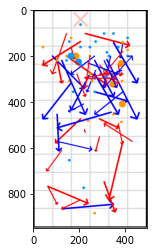

In [37]:
#画像ファイル読み込み
img = cv2.imread("puyopuyo_saikyo_league/stats/test/puyo_field.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

filepath_No = 0

for i in range(len(df_all["Player"])):
    #df_allのスコア行で次のゲームの勝敗を読み込み、矢印の色を決定
    if np.isnan(df_all["Player"].iloc[i])&(filepath_No<games):
        filepath = "puyopuyo_saikyo_league/stats/s1_day8_maki_momoken_2/" + str(filepath_No) + "_6.csv"
        df_game = pd.read_csv(filepath)
        if df_game["Win"][0] == 1:
            color1 = 255
            color2 = 0
        else:
            color1 = 0
            color2 = 255
        filepath_No += 1
    
    #連鎖行で矢印を作成
    #1Pの連鎖で3連鎖以下の場合
    elif (df_all["Player"].iloc[i] == 1) & (df_all["Rensa"].iloc[i] < 4):
        #エラーのときは実行しない
        if (dict_rensa_arrow[df_all["Frame"].iloc[i]][0] != "error") & (dict_rensa_arrow[df_all["Frame_End"].iloc[i]][0] != "error"):
            #エラーでない時は座標を出力
            x1 = dict_rensa_arrow[df_all["Frame"].iloc[i]][0]
            y1 = dict_rensa_arrow[df_all["Frame"].iloc[i]][1]
            x2 = dict_rensa_arrow[df_all["Frame_End"].iloc[i]][0]
            y2 = dict_rensa_arrow[df_all["Frame_End"].iloc[i]][1]
            
            #単発の場合(矢印の始点終点が一致)
            if (x1 == x2) & (y1 == y2):
                #得点が240点以上⇒いばらとして大きな点、240点未満は小さな点を表示
                if df_all["Tokuten"].iloc[i] >= 240:
                    cv2.arrowedLine(img, (x1, y1), (x2, y2), (color1, 150, color2), thickness=30, tipLength=0.1)
                else:
                    cv2.arrowedLine(img, (x1, y1), (x2, y2), (color1, 150, color2), thickness=12, tipLength=0.1)
            #単発以外の時は矢印を表示
            else:
                cv2.arrowedLine(img, (x1, y1), (x2, y2), (color1, 0, color2), thickness=int(df_all["Rensa"].iloc[i]*2), tipLength=0.1)

#png画像で出力
plt.imshow(img)
cv2.imwrite("puyopuyo_saikyo_league/stats/s1_day8_maki_momoken_2/1p_1-5rensa.png", cv2.cvtColor(img, cv2.COLOR_BGR2RGB))